In [399]:
import karhunenLoeve as kl
from matplotlib import pyplot as plt
from matplotlib import colormaps
from matplotlib import colors
from matplotlib.ticker import MaxNLocator
import numpy as np
import time
from scipy.special import kv, gamma
from  scipy.optimize import brentq

import graphSettings

testing of integrals in the Galerkin Method for Spectral Decomposition

## 1D
#### Calculation of W matrix
should be identity matrix due to orthogonality

[[ 1.00000000e+00  7.07767178e-16 -4.59875193e-15  5.29784550e-15]
 [ 7.07767178e-16  1.00000000e+00  5.26510259e-15 -5.97178557e-15]
 [-4.59875193e-15  5.26510259e-15  1.00000000e+00  5.12263842e-15]
 [ 5.29784550e-15 -5.97178557e-15  5.12263842e-15  1.00000000e+00]]


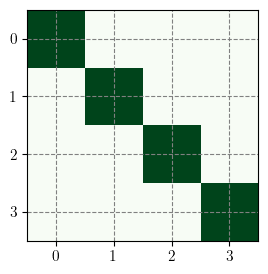

In [400]:

l = lambda x : kl.integ.legendre_normal(x, 100)

matrix_size = 4
matrix = np.zeros((matrix_size,matrix_size))
for i in range(matrix_size):
    for j in range(matrix_size):
        matrix[i,j] = kl.integ.quadrature(lambda x : l(x)[i]*l(x)[j], 100)
print(matrix)

fig, ax = plt.subplots()


ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()

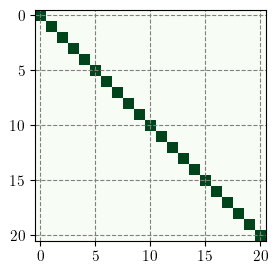

In [401]:
l = lambda x : kl.integ.legendre_normal(x, 20)

n = 50


nodes, weights = kl.integ.nodes_weights(n)

values = l(nodes)


matrix = ((values * weights) @ values.T)

fig, ax = plt.subplots()

ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()


with interval <a,b>:

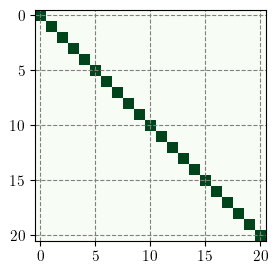

In [402]:
a = 0
b = 5
l = lambda x : kl.integ.legendre_normal(((a+b)/(a-b) + (2/(b-a))*x), 20)

n = 50


nodes, weights = kl.integ.nodes_weights(n)

nodes = (a+b)/2 + (b-a)/2*nodes
weights = weights * (b-a)/2

values = l(nodes)


matrix = ((values * weights) @ values.T)


fig, ax = plt.subplots()

ax.imshow(matrix, cmap=colormaps['Greens'])
plt.show()

## Covariance function

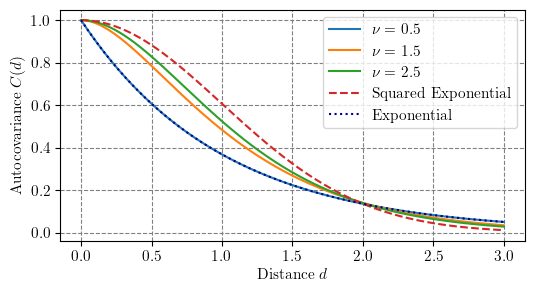

In [403]:
length_scale = 1.0
variance = 1.0
distances = np.linspace(0, 3, 500)

def matern_covariance(d, l, sigma2, nu):
    if np.any(d < 0):
        raise ValueError("Distance d cannot be negative.")
    
    d_safe = np.where(d == 0, 1e-10, d)
    const_part = sigma2 * (2**(1 - nu)) / gamma(nu)
    scaled_dist = np.sqrt(2 * nu) * d_safe / l
    bessel_part = kv(nu, scaled_dist)
    
    cov = const_part * (scaled_dist**nu) * bessel_part
    
    cov[d == 0] = sigma2 
    
    if nu == 0.5:
        cov = sigma2 * np.exp(-d / l)
    elif nu == 1.5:
        cov = sigma2 * (1 + np.sqrt(3) * d / l) * np.exp(-np.sqrt(3) * d / l)
    elif nu == 2.5:
        cov = sigma2 * (1 + np.sqrt(5) * d / l + 5 * d**2 / (3 * l**2)) * np.exp(-np.sqrt(5) * d / l)
        
    return cov


nus = [0.5, 1.5, 2.5]

for nu in nus:
    cov = matern_covariance(distances, length_scale, variance, nu)
    plt.plot(distances, cov, label=f'$\\nu = {nu}$')


sq_exp_cov = variance * np.exp(-(distances**2) / (2 * length_scale**2))
plt.plot(distances, sq_exp_cov, label='Squared Exponential', linestyle='--')


exp_cov = variance * np.exp(-distances / length_scale)
plt.plot(distances, exp_cov, label='Exponential', linestyle=':', color="darkblue")


plt.xlabel('Distance $d$')
plt.ylabel('Autocovariance $C(d)$')
plt.legend()
plt.savefig("CovarienceFunctions.pdf", bbox_inches='tight')
plt.show()

### Intagral with Covariance funtion

In [404]:
l = lambda x : kl.integ.legendre_normal(x, 60)
cov = lambda x,y : np.exp(-np.abs(x-y))

length_scale = 1.0
exp_cov = lambda x,y : variance * np.exp(-np.abs(x-y) / length_scale)
sq_exp_cov = lambda x,y : variance * np.exp(-(np.abs(x-y))**2 / (2 * length_scale**2))
mat_cov = lambda x,y : matern_covariance(np.abs(x-y), length_scale, variance, 2.5)

### Matrix $A$ calculation from different Covarience functions:

##### exponential cov:

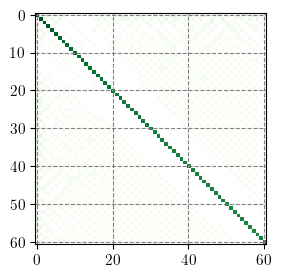

In [405]:
n = 1000

nodes, weights = kl.integ.nodes_weights(n)

nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l(nodes)


PW = (values * weights)
exp_matrix = PW @ (exp_cov(nodesx, nodesy) )@ PW.T


fig, ax = plt.subplots()


ax.imshow(exp_matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

##### squared exponential cov:

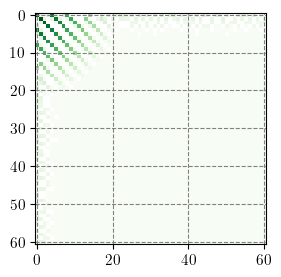

In [406]:
n = 1000

nodes, weights = kl.integ.nodes_weights(n)

nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l(nodes)


PW = (values * weights)
sq_exp_matrix = PW @ (sq_exp_cov(nodesx, nodesy) )@ PW.T

fig, ax = plt.subplots()

ax.imshow(sq_exp_matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

##### matern cov:

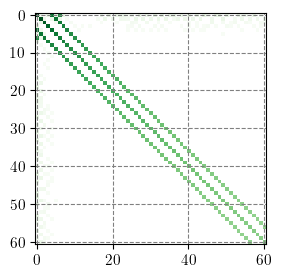

In [407]:
n = 1000

nodes, weights = kl.integ.nodes_weights(n)

nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l(nodes)


PW = (values * weights)
mat_matrix = PW @ (mat_cov(nodesx, nodesy) )@ PW.T


fig, ax = plt.subplots()


ax.imshow(mat_matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

Aij error:

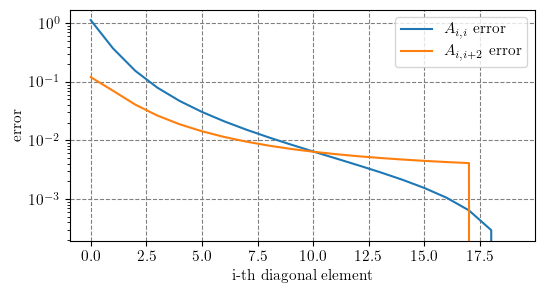

array([0.12036858, 0.07050513, 0.04088707, 0.02651194, 0.01882813,
       0.01430509, 0.01143342, 0.00950096, 0.00814003, 0.00714614,
       0.0063985 , 0.00582211, 0.00536846, 0.00500506, 0.00470949,
       0.00446587, 0.0042627 , 0.00409152, 0.        ])

In [448]:
temp_matrix = exp_matrix[:20,:20]

matrix_size=temp_matrix.shape[0]
errorsii = np.zeros(matrix_size)
errorsij = np.zeros(matrix_size-1)
for i in range(matrix_size):
    errorsii[i] = np.abs(temp_matrix[i,i]-temp_matrix[-1,-1])
    if(i!=0 and i!=1): errorsij[i-2] = np.abs(temp_matrix[i-2,i]-temp_matrix[-1,-1])
plt.yscale("log")
plt.ylabel("error")
plt.xlabel("i-th diagonal element")
plt.plot(errorsii, label = r"$A_{i,i}$ error")
plt.plot(errorsij, label = r"$A_{i,i+2}$ error")
plt.legend()
plt.show()

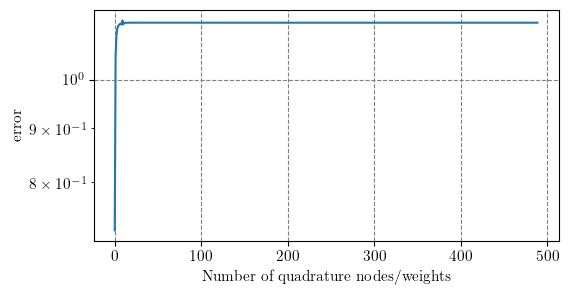

In [446]:
errors = []
for n in range(10,500):
    nodes, weights = kl.integ.nodes_weights(n)

    nodesx, nodesy = np.meshgrid(nodes,nodes)
    values = l(nodes)[:20]

    PW = (values * weights)
    temp_matrix = PW @ (exp_cov(nodesx, nodesy) )@ PW.T

    matrix_size=temp_matrix.shape[0]
    errors.append(np.abs(temp_matrix[0,0]-temp_matrix[-1,-1]))

plt.yscale("log")
plt.ylabel("error")
plt.xlabel("Number of quadrature nodes/weights")
plt.plot(errors)

---
other covs:

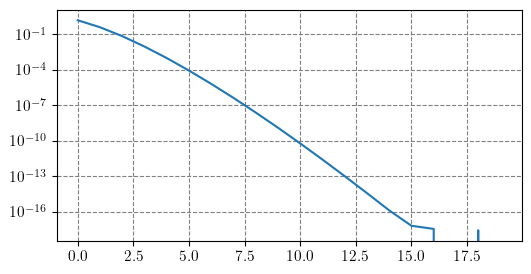

In [424]:
temp_matrix = sq_exp_matrix[:20,:20]

matrix_size=temp_matrix.shape[0]
errors = np.zeros(matrix_size)
for i in range(matrix_size):
    errors[i]=temp_matrix[i,i]-temp_matrix[-1,-1]
plt.yscale("log")
plt.plot(errors)

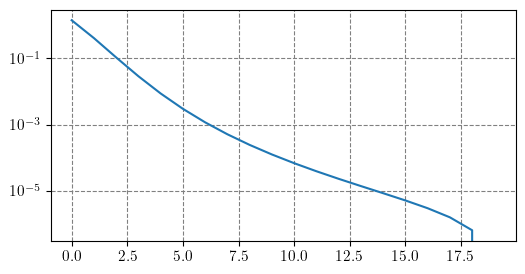

In [425]:
temp_matrix = mat_matrix[:20,:20]

matrix_size=temp_matrix.shape[0]
errors = np.zeros(matrix_size)
for i in range(matrix_size):
    errors[i]=temp_matrix[i,i]-temp_matrix[-1,-1]
plt.yscale("log")
plt.plot(errors)

#### Eigenvalues and eigenfunctions:

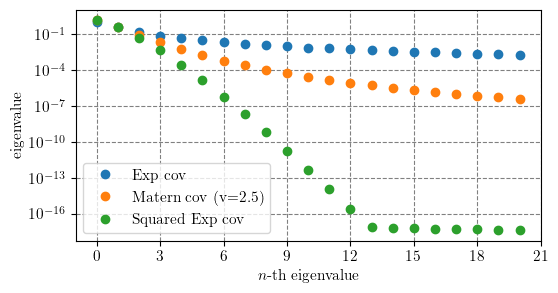

In [408]:
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)

exp_eigenvalues, exp_eigenvectors = np.linalg.eigh(exp_matrix)
exp_eigenvectors_functions = (values.T @ exp_eigenvectors) * np.sqrt(np.maximum(exp_eigenvalues, 0))

sqexp_eigenvalues, sqexp_eigenvectors = np.linalg.eigh(sq_exp_matrix)
sqexp_eigenvectors_functions = (values.T @ sqexp_eigenvectors) * np.sqrt(np.maximum(sqexp_eigenvalues, 0))

mat_eigenvalues, mat_eigenvectors = np.linalg.eigh(mat_matrix)
mat_eigenvectors_functions = (values.T @ mat_eigenvectors) * np.sqrt(np.maximum(mat_eigenvalues, 0))

fig, ax = plt.subplots()
ax.plot(exp_eigenvalues[:-22:-1], 'o', label='Exp cov')
ax.plot(mat_eigenvalues[:-22:-1], 'o', label='Matern cov (v=2.5)')
ax.plot(sqexp_eigenvalues[:-22:-1], 'o', label='Squared Exp cov')
ax.set_yscale("log")
ax.set_xlabel('$n$-th eigenvalue')
ax.set_ylabel('eigenvalue')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.legend()
fig.savefig("eigenvalues.pdf", bbox_inches='tight')
plt.show()

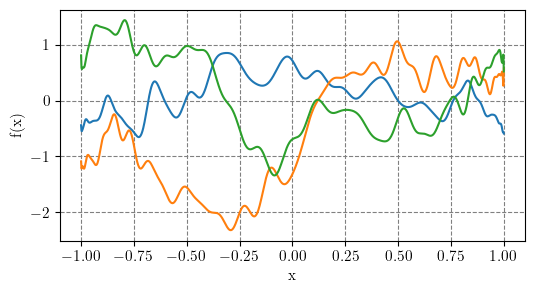

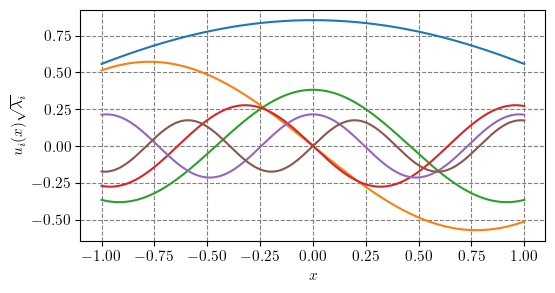

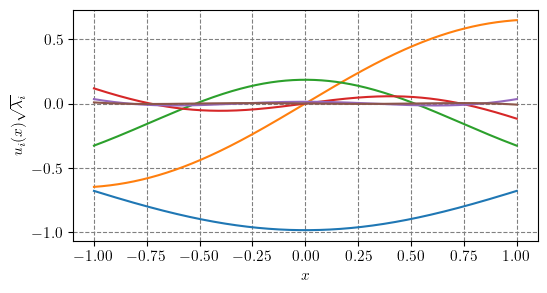

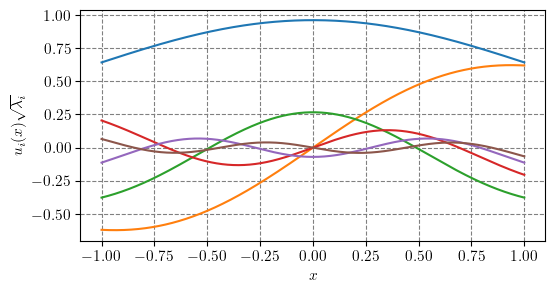

In [409]:

n = exp_eigenvectors_functions.shape[1]

for i in range(3):
    realisation = np.random.normal(size=n)
    realisation = exp_eigenvectors_functions @ realisation

    plt.plot(x_axis, realisation)

plt.xlabel('x')
plt.ylabel('f(x)')
plt.savefig("1Drealization.pdf", bbox_inches='tight')
plt.show()


for i in range(1,7):
    plt.plot(x_axis, exp_eigenvectors_functions.T[-i])

plt.xlabel('$x$')
plt.ylabel(r'$u_{i}(x)\sqrt{\lambda_{i}}$')
plt.savefig("eigenfunctions.pdf", bbox_inches='tight')
plt.show()

for i in range(1,7):
    plt.plot(x_axis, sqexp_eigenvectors_functions.T[-i])

plt.xlabel('$x$')
plt.ylabel(r'$u_{i}(x)\sqrt{\lambda_{i}}$')
plt.show()


for i in range(1,7):
    plt.plot(x_axis, mat_eigenvectors_functions.T[-i])

plt.xlabel('$x$')
plt.ylabel(r'$u_{i}(x)\sqrt{\lambda_{i}}$')
plt.show()

In [200]:
def KL_exp_1D(L, nu, sigma_squared, N):
    
    ce = lambda w: (nu**2 * w**2 - 1) * np.sin(w * L) - 2 * nu * w * np.cos(w * L)

    w, n, eps = [], 1, 1e-12 
    for n in range(1, N + 1):
        a, b = (n - 1) * np.pi / L + eps, n * np.pi / L - eps   
        w.append(brentq(ce, a, b))
    
    w = np.asarray(w)
    lambdas = 2 * nu * sigma_squared / (nu**2 * w**2 + 1.0)
    b = 1 / np.sqrt((nu**2 * w**2 + 1) * L / 2 + nu)
    a = nu * w * b

    f = [(lambda a_, b_, w_: (lambda x, a=a_, b=b_, w=w_: a * np.cos(w * x) + b * np.sin(w * x)))
         (ai, bi, wi) for ai, bi, wi in zip(a, b, w)]
    return lambdas, f
analitic_eigenfunc = KL_exp_1D(2, 1, 1, 21)[1]

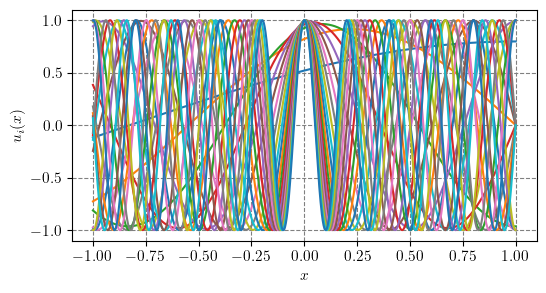

In [201]:
x_axis = np.linspace(-1, 1, 1000)
for fnc in analitic_eigenfunc:
    plt.plot(x_axis,fnc(x_axis))
plt.xlabel('$x$')
plt.ylabel('$u_i(x)$')
plt.show()

### Residuum:

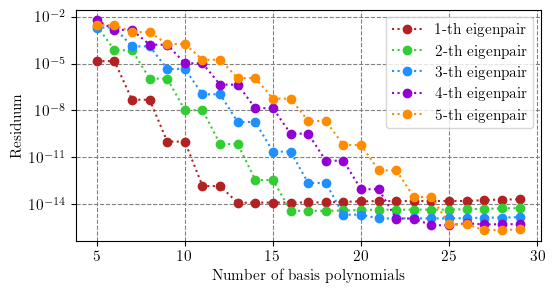

In [397]:
cov = lambda x,y : np.exp(-np.abs(x-y))
max_n=30
l = lambda x : kl.integ.legendre_normal(x, max_n-1)
                
nodes, weights = kl.integ.nodes_weights(1000)
nodesx, nodesy = np.meshgrid(nodes,nodes)

values = l(nodes)

A = (values * weights)
C = cov(nodesx, nodesy)
matrix = A @ C @ A.T

graph_colors = ["firebrick", "limegreen", "dodgerblue", "darkviolet", "darkorange"]
for i in range(5):
    residuum_i = []
    node_range=range(5,max_n)
    for n in node_range:
        temp_matrix = matrix[:n,:n]
        temp_values = values[:n]

        eigenvalues, eigenvectors = np.linalg.eigh(temp_matrix)
        sort_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sort_idx]
        eigenvectors = eigenvectors[:, sort_idx]

        eigenvectors_functions = (temp_values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
        
        eigf = eigenvectors_functions.T[i]
        eigv = eigenvalues[i]

        left_side = C@(eigf*weights)
        right_side = -eigv*eigf
        
        residuum_i.append(np.sqrt(weights @ ((left_side + right_side)**2)))

    #plt.plot(node_range,residuum_i, '--', color=graph_colors[i])
    plt.plot(node_range,residuum_i, 'o:', label=f'{i+1}-th eigenpair', color=graph_colors[i])
plt.xlabel("Number of basis polynomials")
plt.ylabel("Residuum")
plt.legend()
plt.yscale("log")
plt.savefig("EigenpairsResiduum.pdf", bbox_inches='tight')
plt.show()

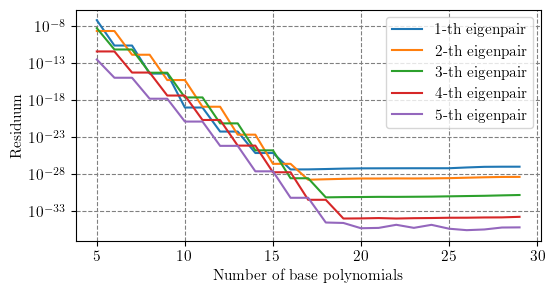

In [235]:
cov = lambda x,y : np.exp(-(np.abs(x-y))**2 / 2)

for i in range(5):
    residuum_i = []
    node_range=range(5,30)
    for n in node_range:
        l = lambda x : kl.integ.legendre_normal(x, n)
                
        nodes, weights = kl.integ.nodes_weights(1000)
        nodesx, nodesy = np.meshgrid(nodes,nodes)

        values = l(nodes)

        A = (values * weights)
        C = cov(nodesx, nodesy)
        matrix = A @ C @ A.T

        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        sort_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sort_idx]
        eigenvectors = eigenvectors[:, sort_idx]

        eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
        
        eigf = eigenvectors_functions.T[i]
        eigv = eigenvalues[i]

        left_side = C@(eigf*weights)
        right_side = -eigv*eigf
        
        residuum_i.append(np.sqrt(weights @ ((left_side + right_side)**2)))

    plt.plot(node_range,residuum_i, label=f'{i+1}-th eigenpair')
plt.xlabel("Number of base polynomials")
plt.ylabel("Residuum")
plt.legend()
plt.yscale("log")
#plt.savefig("EigenpairsResiduum.pdf", bbox_inches='tight')
plt.show()

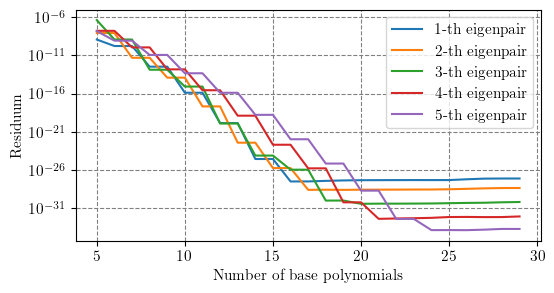

In [236]:
cov = lambda x,y : matern_covariance(np.abs(x-y), length_scale, variance, 2.5)

for i in range(5):
    residuum_i = []
    node_range=range(5,30)
    for n in node_range:
        l = lambda x : kl.integ.legendre_normal(x, n)
                
        nodes, weights = kl.integ.nodes_weights(1000)
        nodesx, nodesy = np.meshgrid(nodes,nodes)

        values = l(nodes)

        A = (values * weights)
        C = cov(nodesx, nodesy)
        matrix = A @ C @ A.T

        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        sort_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sort_idx]
        eigenvectors = eigenvectors[:, sort_idx]

        eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
        
        eigf = eigenvectors_functions.T[i]
        eigv = eigenvalues[i]

        left_side = C@(eigf*weights)
        right_side = -eigv*eigf
        
        residuum_i.append(np.sqrt(weights @ ((left_side + right_side)**2)))

    plt.plot(node_range,residuum_i, label=f'{i+1}-th eigenpair')
plt.xlabel("Number of base polynomials")
plt.ylabel("Residuum")
plt.legend()
plt.yscale("log")
#plt.savefig("EigenpairsResiduum.pdf", bbox_inches='tight')
plt.show()

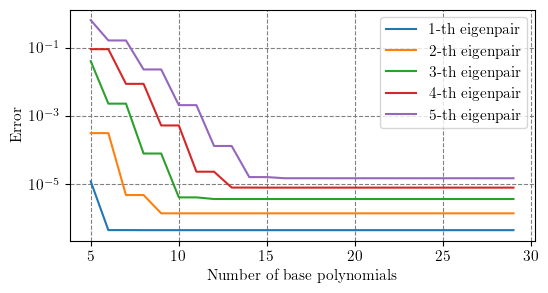

In [246]:
real_eigenvalues, analitic_eigenfunc = KL_exp_1D(2, 1, 1, 21)

cov = lambda x,y : np.exp(-np.abs(x-y))

for i in range(0,5):
    node_range=range(5,30)
    errors = []
    for n in node_range:
        l = lambda x : kl.integ.legendre_normal(x, n)
        
        nodes, weights = kl.integ.nodes_weights(1000)
        nodesx, nodesy = np.meshgrid(nodes,nodes)

        values = l(nodes)

        A = (values * weights)
        C = cov(nodesx, nodesy)
        matrix = A @ C @ A.T

        eigenvalues, eigenvectors = np.linalg.eigh(matrix)
        
        sort_idx = np.argsort(eigenvalues)[::-1]
        eigenvalues = eigenvalues[sort_idx]
        eigenvectors = eigenvectors[:, sort_idx]

        eigenvectors_functions = (values.T @ eigenvectors)
        
        real_eigenfunction = analitic_eigenfunc[i](nodes+1)
        eigf = eigenvectors_functions.T[i]
        errors.append(np.sqrt(weights @ ((eigf.flatten() - np.sign(eigf[0] * real_eigenfunction[1])* real_eigenfunction.flatten())**2)))

    plt.plot(node_range,errors, label=f'{i+1}-th eigenpair')
plt.xlabel("Number of base polynomials")
plt.ylabel("Error")
plt.legend()
plt.yscale("log")
plt.savefig("EigenpairsError.pdf", bbox_inches='tight')
plt.show()


#### Trying over <a,b>:

(21, 50)


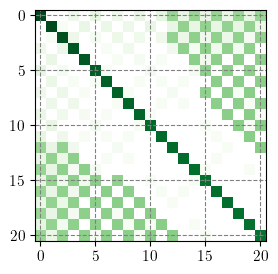

In [12]:
a = -2
b = 1
l = lambda x : kl.integ.legendre_normal(x, 20)
cov = lambda x,y : np.exp(-np.abs(x-y))

n = 50


nodes, weights = kl.integ.nodes_weights(n)

nodes = (a+b)/2 + (b-a)/2*nodes
weights = weights * (b-a)/2


nodesx, nodesy = np.meshgrid(nodes,nodes)
values = l((a+b)/(a-b) + (2/(b-a))*nodes)

A = (values* weights)
matrix = A @ cov(nodesx, nodesy) @ A.T


fig, ax = plt.subplots()

ax.imshow(matrix, cmap=colormaps['Greens'], norm=colors.LogNorm())
plt.show()

(21, 1000) (21,) (21, 21) (1000, 21)
(1000, 21) (21,)


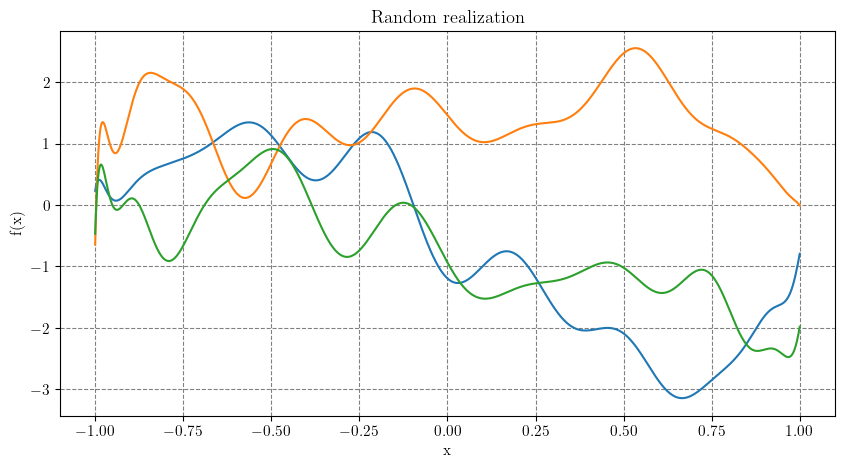

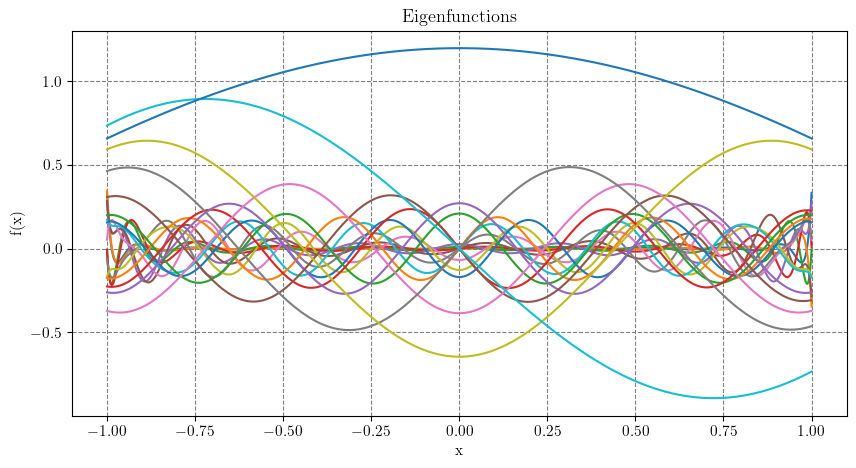

In [13]:

eigenvalues, eigenvectors = np.linalg.eigh(matrix)
x_axis = np.linspace(-1, 1, 1000)
values = l(x_axis)
eigenvectors_functions = (values.T @ eigenvectors) * np.sqrt(np.maximum(eigenvalues, 0))
print(values.shape, eigenvalues.shape, eigenvectors.shape, eigenvectors_functions.shape)
print((values.T @ eigenvectors).shape, np.sqrt(np.maximum(eigenvalues, 0)).shape)


n = eigenvectors_functions.shape[1]

plt.figure(figsize=(10, 5))
for i in range(3):
    realisation = np.random.normal(size=n)
    realisation = eigenvectors_functions @ realisation

    plt.plot(x_axis, realisation)


plt.title('Random realization')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()


plt.figure(figsize=(10, 5))
for fnc in eigenvectors_functions.T:
    plt.plot(x_axis, fnc)
plt.title('Eigenfunctions')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.show()

---
## 2D

Obtaining a 4D tensor A and making it into 2D tensor

In [472]:
poly_count = 18
l = lambda x: kl.integ.legendre_normal(x, poly_count)

n = 100


nodes, weights = kl.integ.nodes_weights(n)

nodesx1 = np.reshape(nodes, (-1, 1, 1, 1))
nodesy1 = np.reshape(nodes, (1, -1, 1, 1))
nodesx2 = np.reshape(nodes, (1, 1, -1, 1))
nodesy2 = np.reshape(nodes, (1, 1, 1, -1))
values = l(nodes)

dist_sq = (nodesx1 - nodesx2)**2 + (nodesy1 - nodesy2)**2
lamb = 1
C_tensor_exp = np.exp(-np.sqrt(dist_sq)/lamb)


PW = (values* weights)
A_tensor_exp = np.einsum('kp,lq,pqrs,ir,js->klij', PW, PW, C_tensor_exp, PW, PW, optimize=True)
A_matrix_exp = np.reshape(A_tensor_exp, ((poly_count+1)**2,(poly_count+1)**2))

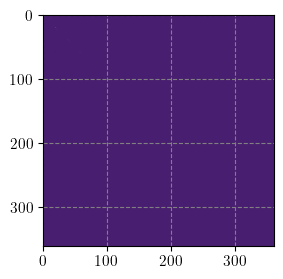

In [473]:
plt.imshow(A_matrix_exp)

Making eigenfunctions:

In [475]:
eigenvalues_exp, eigenvectors_exp = np.linalg.eigh(A_matrix_exp)
x_axis = np.linspace(-1, 1, 200)
values = l(x_axis)

V1 = values[:, np.newaxis, np.newaxis, :]
V2 = values[np.newaxis, :, :, np.newaxis]
V = V1 * V2
V = np.reshape(V, (len(V)**2,len(x_axis),len(x_axis)))
eigenvectors_functions_exp = (np.einsum('ijk,in->njk', V, eigenvectors_exp, optimize=True).T * np.sqrt(np.maximum(eigenvalues_exp, 0))).T
    

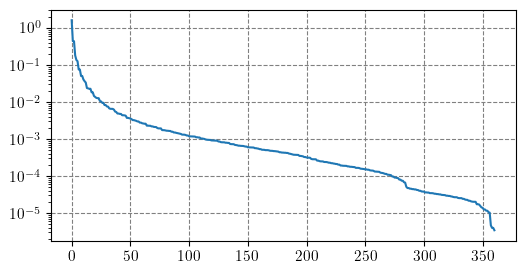

In [476]:
plt.plot(eigenvalues_exp[::-1])
plt.yscale('log')
plt.show()

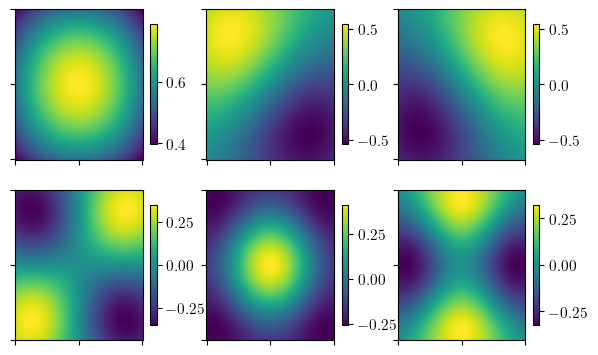

In [477]:
fig, axs = plt.subplots(2, 3, figsize=(7, 4.3))
fig.subplots_adjust(wspace=0.2)
for i in range(6):
    if(i<3): 
        mesh= axs[0,i].pcolormesh(x_axis, x_axis, eigenvectors_functions_exp[-i-1])
        mesh.set_rasterized(True)
        axs[0,i].set_xticklabels([])
        axs[0,i].set_yticklabels([])
        axs[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].grid(False)
        fig.colorbar(mesh, ax=axs[0,i], shrink=0.8)
    else:
        mesh= axs[1,i-3].pcolormesh(x_axis, x_axis, eigenvectors_functions_exp[-i-1])
        mesh.set_rasterized(True)
        axs[1,i-3].set_xticklabels([])
        axs[1,i-3].set_yticklabels([])
        axs[1,i-3].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].grid(False)
        fig.colorbar(mesh, ax=axs[1,i-3], shrink=0.8)

plt.savefig("Eigenfunctions2D.pdf", bbox_inches='tight')
plt.show()

Random fields samples:

minimal value: -3.250761621944529
maximal value: 3.017209381417947
value interval size: 6.267971003362476


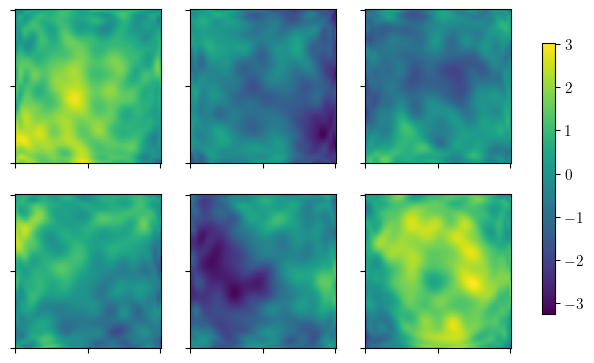

In [478]:
n = eigenvectors_functions_exp.shape[0]

all_realizations = []
fig, axs = plt.subplots(2, 3, figsize=(8, 4.4))
for i in range(6):
    realisation = np.random.normal(size=n)
    realisation = eigenvectors_functions_exp.T @ realisation
    all_realizations.append(realisation)

vmin_global = min(data.min() for data in all_realizations)
vmax_global = max(data.max() for data in all_realizations)

print("minimal value:", vmin_global)
print("maximal value:", vmax_global)
print("value interval size:", vmax_global-vmin_global)

for i in range(6):
    realisation = all_realizations[i]
    if(i<3): 
        mesh = axs[0,i].pcolormesh(x_axis, x_axis, realisation, vmin=vmin_global, vmax=vmax_global)
        mesh.set_rasterized(True)
        axs[0,i].set_xticklabels([])
        axs[0,i].set_yticklabels([])
        axs[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].grid(False)
    else:
        mesh = axs[1,i-3].pcolormesh(x_axis, x_axis, realisation, vmin=vmin_global, vmax=vmax_global)
        mesh.set_rasterized(True)
        axs[1,i-3].set_xticklabels([])
        axs[1,i-3].set_yticklabels([])
        axs[1,i-3].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].grid(False)

fig.colorbar(mesh, ax=axs, location='right', shrink=0.8)

fig.savefig("2DRealization.pdf", bbox_inches='tight')
plt.show()

##### Now using my KarhunenLoeve library:

In [508]:

def C_exp(x1,x2,y1,y2):
    dist_sq = (x1 - x2)**2 + (y1 - y2)**2
    return np.exp(-np.sqrt(dist_sq))
def C_sqexp(x1,x2,y1,y2):
    dist_sq = (x1 - x2)**2 + (y1 - y2)**2
    return np.exp(-dist_sq)
def C_mat(x1,x2,y1,y2): # need to figure out how
    dist_sq = (x1 - x2)**2 + (y1 - y2)**2
    return np.exp(-np.sqrt(dist_sq))

x = np.linspace(-1, 1, 500)


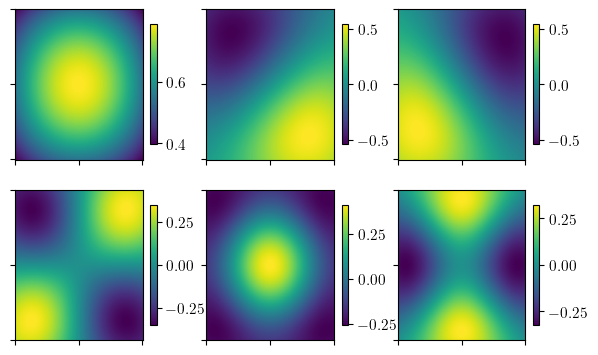

In [511]:

eigenfunctions_exp = kl.get_eigenfuntions(x, C_exp, 30, 100)
fig, axs = plt.subplots(2, 3, figsize=(7, 4.3))

for i in range(6):
    if(i<3): 
        mesh= axs[0,i].pcolormesh(x, x, eigenfunctions_exp[-i-1])
        mesh.set_rasterized(True)
        axs[0,i].set_xticklabels([])
        axs[0,i].set_yticklabels([])
        axs[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].grid(False)
        fig.colorbar(mesh, ax=axs[0,i], shrink=0.8)
    else:
        mesh= axs[1,i-3].pcolormesh(x, x, eigenfunctions_exp[-i-1])
        mesh.set_rasterized(True)
        axs[1,i-3].set_xticklabels([])
        axs[1,i-3].set_yticklabels([])
        axs[1,i-3].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].grid(False)
        fig.colorbar(mesh, ax=axs[1,i-3], shrink=0.8)

plt.savefig("Eigenfunctions2DExp.pdf", bbox_inches='tight')
plt.show()

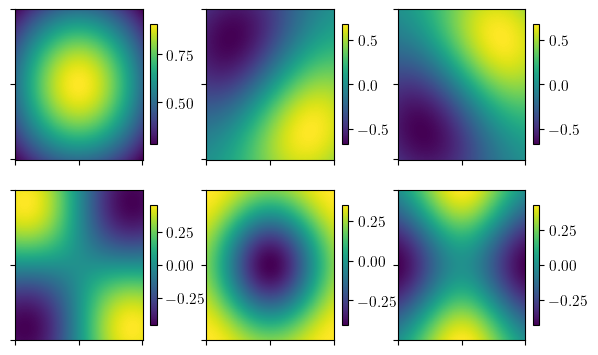

In [512]:
eigenfunctions_sqexp = kl.get_eigenfuntions(x, C_sqexp, 30, 100)
fig, axs = plt.subplots(2, 3, figsize=(7, 4.3))

for i in range(6):
    if(i<3): 
        mesh= axs[0,i].pcolormesh(x, x, eigenfunctions_sqexp[-i-1])
        mesh.set_rasterized(True)
        axs[0,i].set_xticklabels([])
        axs[0,i].set_yticklabels([])
        axs[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].grid(False)
        fig.colorbar(mesh, ax=axs[0,i], shrink=0.8)
    else:
        mesh= axs[1,i-3].pcolormesh(x, x, eigenfunctions_sqexp[-i-1])
        mesh.set_rasterized(True)
        axs[1,i-3].set_xticklabels([])
        axs[1,i-3].set_yticklabels([])
        axs[1,i-3].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].grid(False)
        fig.colorbar(mesh, ax=axs[1,i-3], shrink=0.8)

plt.savefig("Eigenfunctions2DSqExp.pdf", bbox_inches='tight')
plt.show()

minimal value: -2.8285401497729414
maximal value: 2.5993473276976866
value interval size: 5.4278874774706285


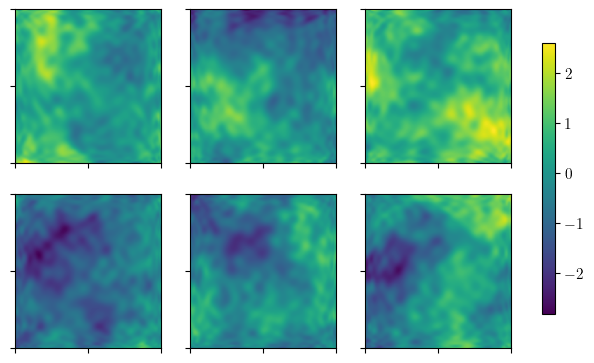

In [515]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4.4))

all_realizations = []
for i in range(6):
    realisation = kl.sample_normal(eigenfunctions_exp)
    all_realizations.append(realisation)

vmin_global = min(data.min() for data in all_realizations)
vmax_global = max(data.max() for data in all_realizations)

print("minimal value:", vmin_global)
print("maximal value:", vmax_global)
print("value interval size:", vmax_global-vmin_global)

for i in range(6):
    realisation = all_realizations[i]
    if(i<3): 
        mesh = axs[0,i].pcolormesh(x, x, realisation, vmin=vmin_global, vmax=vmax_global)
        mesh.set_rasterized(True)
        axs[0,i].set_xticklabels([])
        axs[0,i].set_yticklabels([])
        axs[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].grid(False)
    else:
        mesh = axs[1,i-3].pcolormesh(x, x, realisation, vmin=vmin_global, vmax=vmax_global)
        mesh.set_rasterized(True)
        axs[1,i-3].set_xticklabels([])
        axs[1,i-3].set_yticklabels([])
        axs[1,i-3].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].grid(False)

fig.colorbar(mesh, ax=axs, location='right', shrink=0.8)

fig.savefig("2DRealizationExp.pdf", bbox_inches='tight')
plt.show()

minimal value: -2.667643000091871
maximal value: 2.4704331380344957
value interval size: 5.138076138126367


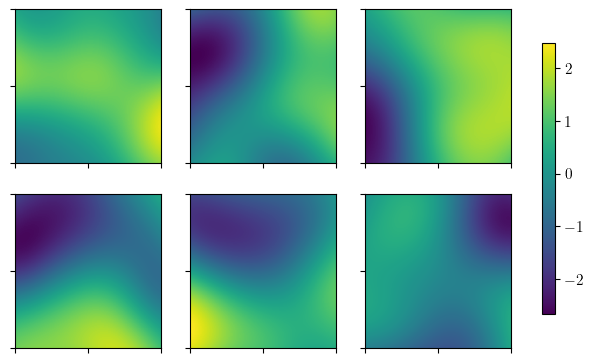

In [516]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4.4))

all_realizations = []
for i in range(6):
    realisation = kl.sample_normal(eigenfunctions_sqexp)
    all_realizations.append(realisation)

vmin_global = min(data.min() for data in all_realizations)
vmax_global = max(data.max() for data in all_realizations)

print("minimal value:", vmin_global)
print("maximal value:", vmax_global)
print("value interval size:", vmax_global-vmin_global)

for i in range(6):
    realisation = all_realizations[i]
    if(i<3): 
        mesh = axs[0,i].pcolormesh(x, x, realisation, vmin=vmin_global, vmax=vmax_global)
        mesh.set_rasterized(True)
        axs[0,i].set_xticklabels([])
        axs[0,i].set_yticklabels([])
        axs[0,i].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[0,i].grid(False)
    else:
        mesh = axs[1,i-3].pcolormesh(x, x, realisation, vmin=vmin_global, vmax=vmax_global)
        mesh.set_rasterized(True)
        axs[1,i-3].set_xticklabels([])
        axs[1,i-3].set_yticklabels([])
        axs[1,i-3].xaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].yaxis.set_major_locator(MaxNLocator(integer=True))
        axs[1,i-3].grid(False)

fig.colorbar(mesh, ax=axs, location='right', shrink=0.8)

fig.savefig("2DRealizationsqExp.pdf", bbox_inches='tight')
plt.show()

Lets see how of the integrals of same polynomials with a C_tensor look like as graphs

In [495]:
l = lambda x : kl.integ.legendre_normal(x, 100)

In [496]:
n = 10

lamb = 10
aprox = []
node_range = range(20,100)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)

Integral result:

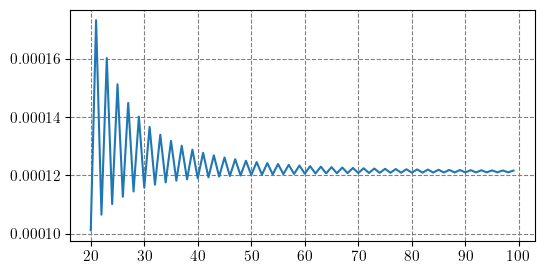

In [497]:
plt.plot(node_range,aprox)
plt.show()

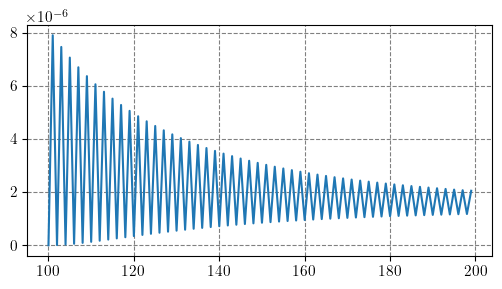

In [498]:
n = 100

lamb = 1
aprox = []
node_range = range(100,200)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-np.sqrt(dist_sq)/lamb)
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)
plt.plot(node_range,aprox)
plt.show()

### Lets have a different C

In [499]:
n = 4

lamb = 1
aprox = []
difference = []
node_range = range(15,100)
for node_count in node_range:
    nodes, weights = kl.integ.nodes_weights(node_count)
    nodesx = np.reshape(nodes, (-1, 1))
    nodesy = np.reshape(nodes, (1, -1))
    dist_sq = (nodesx)**2 + (nodesy)**2
    C_tensor = np.exp(-dist_sq/lamb)
    int_aprox =(l(nodes)[n]*weights) @ C_tensor @ (l(nodes)[n]*weights)
    aprox.append(int_aprox)
    difference.append(np.abs(int_aprox-0.0164274897245295915177756431842263468086376299790787366359421403395269788))

Integral result:

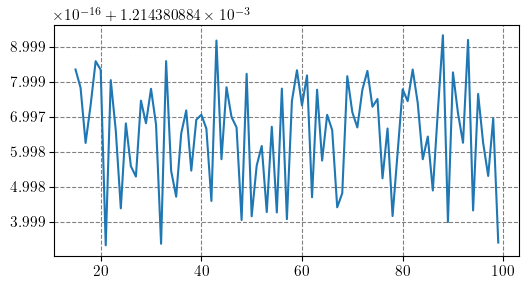

In [500]:
plt.plot(node_range,aprox)
plt.show()

Difference from real value:

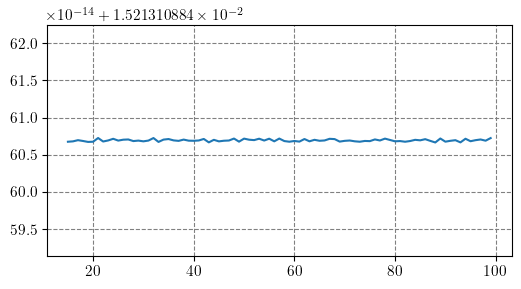

In [501]:
plt.plot(node_range,difference)
plt.show()

In [502]:
n = 4

lamb = 1
aprox = []
difference = []
times = []
node_range = range(15,500)
for node_count in node_range:
    starttime = time.time()
    nodes, weights = kl.integ.nodes_weights(node_count)
    dist_sq = (nodes)**2
    C_tensor = np.exp(-dist_sq/lamb)
    int_aprox =((l(nodes)[n]*weights) @ C_tensor)**2
    endtime = time.time()

    aprox.append(int_aprox)
    difference.append(np.abs(int_aprox-0.0164274897245295915177756431842263468086376299790787366359421403395269788))
    times.append(endtime-starttime)


Integral result:

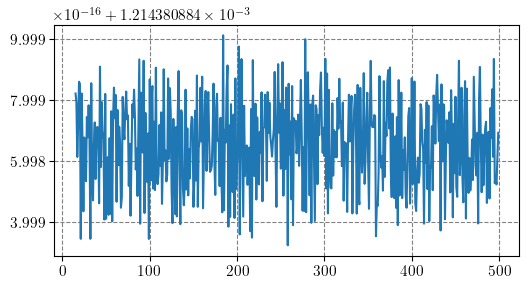

In [503]:
plt.plot(node_range,aprox)
plt.show()

Difference from real value:

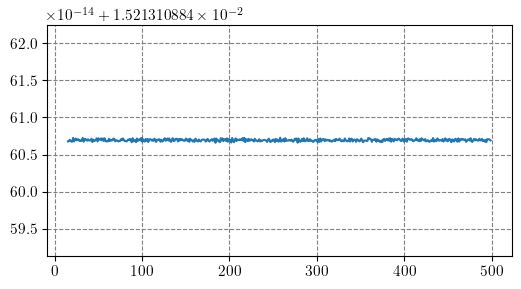

In [504]:
plt.plot(node_range,difference)
plt.show()

Time graph

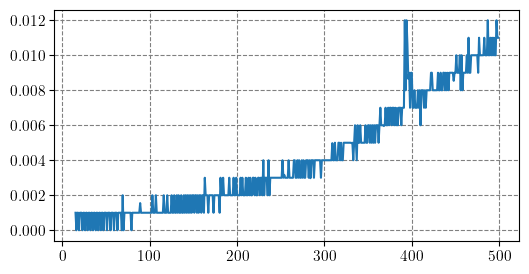

In [505]:
plt.plot(node_range,times)
plt.show()